In [81]:
# Import Package
import pandas as pd
import json
import re
import string
import wordcloud
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import nltk

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel, LdaModel, LdaMulticore

from pprint import pprint

import pyLDAvis
import pyLDAvis.gensim  # don't skip this

pd.set_option('display.max_colwidth', -1)
sns.set_style('whitegrid')
%matplotlib inline

<ipython-input-81-54dd48cf99bd>:24: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [82]:
# import data
data = pd.read_csv('clean_reviews.csv')

In [83]:
data.head(2)

,userName,at,content,sentiment_score,reviewLength,wordCount
0,Roscoe Bass,2020-11-17 02:23:46,"Ever since the 1.1 update this game is completely unplayable on mobile. Everytime I play the graphics stutter heavily to the point that the game eventually just freezes. This rarely happened before the update, but now it's a constant effect everytime I try to play. It's a shame, really, cause this game WAS amazing. I was planning to spend some $$ to help the devs but now what's the point if I can't even play the game?",Negative,421,77
1,Miguel Lopez,2020-11-15 20:22:26,"Game keeps freezing up & crashing my Pixel 3a 😑 No gamepad support. Tired of game developers not including support for gamepad controls that would make games like this one much more enjoyable to play on a small screen. The game is beautiful and has great voice acting, but instead of making it 100 percent complete, they decide to skip on something very useful and wanted by many. Who knows if they'll add gamepad support later, but it's something that should be there from day one 😑",Negative,483,87


## Overview

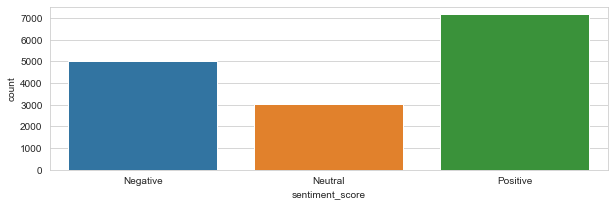

In [84]:
# Reviews count per score

plt.figure(figsize=(10,3))
sns.countplot(x=data['sentiment_score'])

Note : Dataset labels is not balance

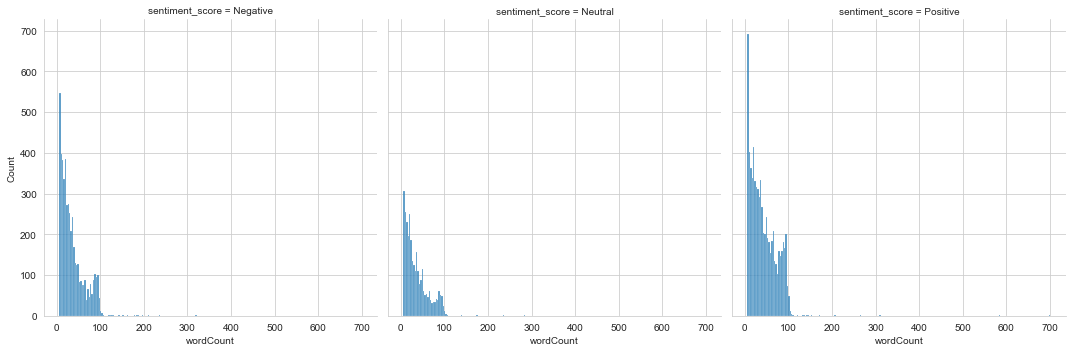

In [85]:
# Number of words in the reviews per score

sns.displot(x=data['wordCount'],col=data['sentiment_score'])

In [86]:
# num of word in the reviews

data.groupby('sentiment_score')['wordCount'].describe()

,count,mean,std,min,25%,50%,75%,max
sentiment_score,,,,,,,,
Negative,5000.0,35.620800,26.861454,6.0,15.0,27.0,49.0,321.0
Neutral,3046.0,35.649376,26.020199,6.0,15.0,28.0,49.0,285.0
Positive,7155.0,42.315164,29.663673,6.0,18.0,36.0,62.5,701.0


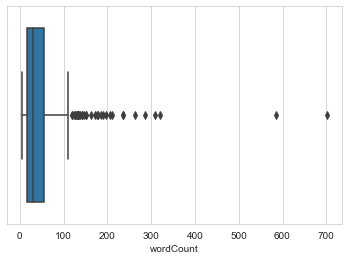

In [87]:
# boxplot

sns.boxplot(x=data['wordCount'])

# Processing

In [128]:
# Tokenizer

with open('cont_en.json') as file:         # import contraction dictionary
    contEn = json.load(file)
    
c_re = re.compile('(%s)' % '|'.join(contEn.keys()))

def expandContractions(text, c_re=c_re):         # expanding contractiion into full form word. ex: won't -> will not
    def replace(match):
        return contEn[match.group(0)]
    return c_re.sub(replace, text.lower())

def stars(text):
    if '*' in text:
        word = text.replace('*',' stars') # replacing * symbol with "star"
    else:
        word = text
    return word

def num2word(text):                        #convert number to string
    if len(text) == 1 and text in '12345':
        if text == '1':
            word = 'one'
        elif text == '2':
            word = 'two'
        elif text == '3':
            word = 'three'
        elif text == '4':
            word = 'four'
        elif text == '5':
            word = 'five'
        else:
            word = text
    else:
        word = text
    return word

def lemma(word, tags=['NOUN','PROPN','VERB']):    # spaCy Lemmatizer
    lemma_doc = nlp(" ".join(word)) 
    lemma_text = [token.text if '_' in token.text else token.lemma_ for token in lemma_doc if token.pos_ in tags]
    return lemma_text

In [292]:
# spacy stopword

nlp = spacy.load("en_core_web_sm")
nlp.Defaults.stop_words -= {"one", "two","three","four","five"} #removing these word from stop_word
stopword = list(STOP_WORDS)

#=== custom stopword ==========

stopword2 = stopword
stopword2.extend(['great','good','like','game','feel','thing','hour','time','play']) # add words into stopword list

In [293]:
def clean_token(text):
    text = stars(text)
    text = expandContractions(text)
    text = re.split(r'\W+',text)
    text = [num2word(x) for x in text]
    text = [x for x in text if x not in string.punctuation]
    text = ["have" if x == "ve" else x for x in text]
    text = ["game" if x == "games" else x for x in text]
    text = ["phone" if x == "mobile" else x for x in text]
    text = ' '.join(text).replace('one one','1.1').split()
    text = [x for x in text if x not in stopword2 and len(x) > 1 and len(x) <= 45]
    return text

In [294]:
# creating token columns

data['token'] = data['content'].apply(clean_token)

In [295]:
# add n-grams

bigram = gensim.models.Phrases(list(data['token']), min_count=5, threshold=10) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [296]:
# lemmatize n-grams and removing stopword from n-grams (double check)

def bigrams(bow):
    text = [x for x in bow if x not in stopword2 and len(x) > 1 and len(x) <= 45]
    text = bigram[text]
    text = lemma(text)
    return text

def unigrams(bow):
    text = [x for x in bow if x not in stopword2 and len(x) > 1 and len(x) <= 45]
    text = lemma(text)
    return text

In [297]:
data['bigram_tag'] = data['token'].apply(bigrams)
data['unigram_tag'] = data['token'].apply(unigrams)

## Word Cloud

In [298]:
pos_list = []
for i in data[data.sentiment_score == 'Positive']['bigram_tag']:
    for j in i:
        if j not in stopword2:
            pos_list.append(j)

Posfreq = nltk.FreqDist(pos_list)
print("Most Common words in Positive Reviews")
print(Posfreq.most_common(100))
print()

net_list = []
for i in data[data.sentiment_score == 'Neutral']['bigram_tag']:
    for j in i:
        if j not in stopword2:
            net_list.append(j)

Netfreq = nltk.FreqDist(net_list)
print("Most Common words in Neutral Reviews")
print(Netfreq.most_common(100))
print()

neg_list = []
for i in data[data.sentiment_score == 'Negative']['bigram_tag']:
    for j in i:
        if j not in stopword2:
            neg_list.append(j)

Negfreq = nltk.FreqDist(neg_list)
print("Most Common words in Negative Reviews")
print(Negfreq.most_common(100))

Most Common words in Positive Reviews
[('phone', 2486), ('graphic', 1413), ('character', 1358), ('love', 1280), ('story', 1019), ('gameplay', 753), ('problem', 666), ('fun', 662), ('need', 639), ('lot', 560), ('open_world', 539), ('control', 514), ('fix', 485), ('world', 479), ('pc', 466), ('experience', 457), ('want', 456), ('hope', 441), ('update', 441), ('gacha', 422), ('issue', 411), ('add', 407), ('wish', 407), ('player', 388), ('way', 384), ('quest', 376), ('enjoy', 365), ('try', 364), ('lag', 359), ('think', 350), ('work', 348), ('five_star', 331), ('rpg', 311), ('system', 294), ('device', 290), ('run', 286), ('look', 285), ('use', 282), ('level', 280), ('five_stars', 278), ('bit', 277), ('come', 271), ('resin', 264), ('download', 255), ('start', 254), ('co_op', 250), ('know', 246), ('thank', 241), ('find', 240), ('friend', 236), ('support', 235), ('combat', 231), ('bug', 227), ('storyline', 223), ('people', 223), ('explore', 221), ('change', 218), ('recommend', 203), ('rate', 2

In [299]:
#turn the word list into a str for wordcloud generation
# pos = ' '.join(w for w in pos_list)
# net = ' '.join(w for w in net_list) 
# neg = ' '.join(w for w in neg_list)

# Generate wordcloud:
wcdpos = wordcloud.WordCloud(width = 2000, height=1000, max_words = 60, stopwords=stopword2,background_color="white").generate_from_frequencies(Posfreq)
wcdnet = wordcloud.WordCloud(width = 2000, height=1000, max_words = 60, stopwords=stopword2,background_color="white").generate_from_frequencies(Netfreq)
wcdneg = wordcloud.WordCloud(width = 2000, height=1000, max_words = 60, stopwords=stopword2,background_color="white").generate_from_frequencies(Negfreq)

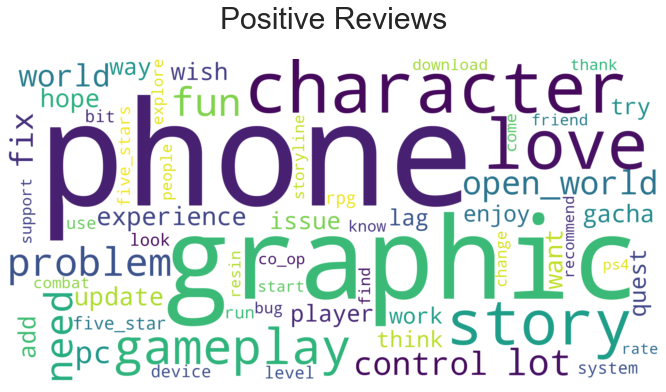

In [300]:
plt.figure(figsize=(16,6))
plt.title("Positive Reviews", fontdict={'fontsize': 30},pad=30)
plt.imshow(wcdpos, interpolation='bilinear')
plt.axis("off")
plt.show()

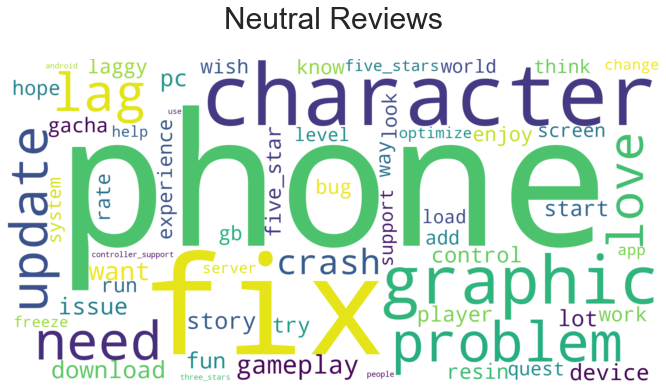

In [301]:
plt.figure(figsize=(16,6))
plt.title("Neutral Reviews", fontdict={'fontsize': 30},pad=30)
plt.imshow(wcdnet, interpolation='bilinear')
plt.axis("off")
plt.show()

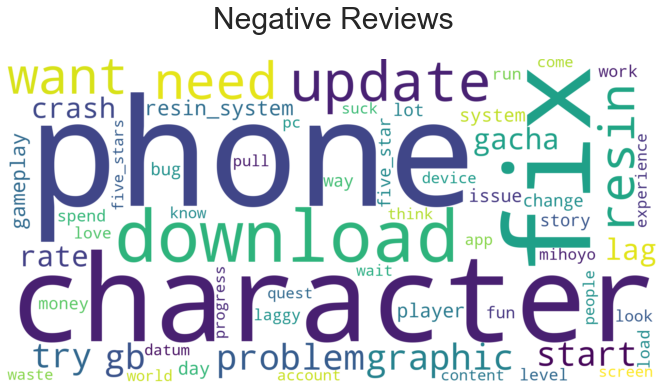

In [302]:
plt.figure(figsize=(16,6))
plt.title("Negative Reviews", fontdict={'fontsize': 30},pad=30)
plt.imshow(wcdneg, interpolation='bilinear')
plt.axis("off")
plt.show()

# Latent Dirichlet Allocation - Topic Modelling

In [303]:
doc = list(data['bigram_tag']) #bag of word
id2word = corpora.Dictionary(doc) # create dictionary
texts = doc # create cropus
corpus = [id2word.doc2bow(text) for text in texts]

In [304]:
# Build LDA model
lda = LdaMulticore(corpus=corpus,
                       id2word=id2word,
                       num_topics=10,
                       random_state=42,
                       eval_every=None,
                       chunksize=1000,
                       passes=100,
                       minimum_probability=0.06,
                       gamma_threshold=0.05,
                       alpha=0.08,
                       per_word_topics=True)

In [305]:
# Perplexity
print('\nPerplexity: ', lda.log_perplexity(corpus))

# Coherence Score
coherenceLda = CoherenceModel(model=lda, texts=doc, dictionary=id2word, coherence='c_v')
coherence = coherenceLda.get_coherence()
print('\nCoherence Score: ', coherence)
print()

# list of n-topics
pprint(lda.print_topics())


Perplexity:  -7.335126727361421

Coherence Score:  0.5264999507458412

[(0,
  '0.039*"resin" + 0.026*"need" + 0.022*"resin_system" + 0.020*"player" + '
  '0.019*"level" + 0.015*"day" + 0.013*"system" + 0.011*"increase" + '
  '0.010*"limit" + 0.010*"progress"'),
 (1,
  '0.032*"love" + 0.028*"play" + 0.025*"open_world" + 0.024*"graphic" + '
  '0.019*"fun" + 0.017*"gameplay" + 0.017*"rpg" + 0.017*"world" + '
  '0.016*"phone" + 0.014*"character"'),
 (2,
  '0.104*"update" + 0.081*"download" + 0.044*"gb" + 0.022*"datum" + '
  '0.019*"storage" + 0.018*"space" + 0.016*"need" + 0.013*"take" + 0.012*"app" '
  '+ 0.010*"start"'),
 (3,
  '0.030*"phone" + 0.017*"sound" + 0.017*"way" + 0.016*"work" + 0.012*"need" + '
  '0.011*"people" + 0.011*"review" + 0.010*"look" + 0.010*"experience" + '
  '0.010*"lot"'),
 (4,
  '0.035*"control" + 0.027*"camera" + 0.023*"fight" + 0.022*"enemy" + '
  '0.020*"button" + 0.018*"aim" + 0.016*"attack" + 0.014*"character" + '
  '0.013*"auto" + 0.010*"battle"'),
 (5,
  

In [350]:
# Topic visualization

pyLDAvis.enable_notebook()
visualTopic = pyLDAvis.gensim.prepare(lda, corpus, id2word, sort_topics=False)
visualTopic

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.019160  0.234714  1       1        11.536102
1      0.179852 -0.043855  2       1        13.235319
2     -0.251403  0.119995  3       1        7.041413 
3     -0.061398 -0.079114  4       1        5.927629 
4     -0.006162 -0.094977  5       1        6.146959 
5     -0.174487 -0.063018  6       1        12.478223
6      0.020290 -0.165777  7       1        13.776347
7      0.203197 -0.036961  8       1        8.340905 
8      0.145267  0.171138  9       1        13.561736
9     -0.074316 -0.042146  10      1        7.955362 , topic_info=         Term         Freq        Total Category  logprob  loglift
9    phone     4357.000000  4357.000000  Default  30.0000  30.0000
15   update    1192.000000  1192.000000  Default  29.0000  29.0000
207  story     1400.000000  1400.000000  Default  28.0000  28.0000
218  download  927.000000   927.000000   Default  27.0000  27.0000
39   fix       1434.000000  1434.000000  Default  26.0000  26.0000
..   ...               ...          ...      ...      ...      ...
310  look      76.844513    540.296387   Topic10 -5.1220   0.5810 
172  go        76.681992    610.749878   Topic10 -5.1241   0.4563 
26   know      68.660919    515.870239   Topic10 -5.2346   0.5146 
48   try       70.080070    799.017151   Topic10 -5.2141   0.0976 
109  need      71.385399    1292.543701  Topic10 -5.1957  -0.3650 

[651 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
35    1      0.179414  1.1_update  
35    10     0.797395  1.1_update  
3188  7      0.974989  3gb_ram     
193   7      0.983178  60fps       
403   1      0.036245  account     
...  ..           ...    ...       
1414  4      0.769598  youtube     
1876  2      0.978558  zelda       
962   2      0.893158  zelda_breath
962   5      0.076556  zelda_breath
853   5      0.981397  zoom        

[1313 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [351]:
# p = pyLDAvis.gensim.prepare(topic_model, corpus, dictionary)
pyLDAvis.save_html(visualTopic, 'lda.html')

In [307]:
# Topic per reviews

def whattopic(model=lda, corpus=corpus, texts=data):
    # Init output
    topicreviews = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(model[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Topic Contribution and Keywords for reviews
        for j, (n_topic, contri_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = model.show_topic(n_topic)
                keywords = ", ".join([word for word, prop in wp])
                topicreviews = topicreviews.append(pd.Series([int(n_topic), round(contri_topic,3), keywords]), ignore_index=True)
            else:
                break
    topicreviews.columns = ['topic', 'topicContribution', 'topicKeyword']

    # content to the end of the output
    contents = pd.Series(texts)
    topicreviews = pd.concat([topicreviews, contents], axis=1)
    return topicreviews

In [333]:
data_topic = whattopic(model=lda, corpus=corpus, texts=doc)

In [335]:
topicReviews = data_topic.reset_index()
topicReviews.columns = ['reviews', 'topic', 'topicContribution', 'topicKeyword', 'content']

# Get keyword for each topic
# for i in topicReviews.topic.unique():
#     print(f'topic {i}:')
#     print('keys :')
#     print(topicReviews[topicReviews['topic']==i]['topicKeyword'].unique())

## Topic Labelling:

#### topic 0.0: Resin/Stamina System
keys : ['resin, need, resin_system, level, player, rate, day, primogem, system, increase']

#### topic 1.0: Game Mechanic
keys : ['love, play, open_world, graphic, rpg, world, fun, phone, gameplay, story']

#### topic 2.0: Update size
keys : ['update, download, gb, datum, storage, space, need, take, app, size']

#### topic 3.0: Misc
keys : ['phone, way, sound, work, play, review, lot, people, need, experience']

#### topic 4.0: Action Control
keys : ['control, camera, enemy, fight, button, attack, aim, auto, character, screen']

#### topic 5.0: Lagging and Crashing
keys : ['fix, problem, lag, crash, issue, start, load, love, server, freeze']

#### topic 6.0: Controller Support
keys : ['phone, pc, graphic, play, device, support, run, ps4, android, control']

#### topic 7.0: Game Feature
keys : ['story, graphic, character, love, gameplay, storyline, world, quest, graphics, music']

#### topic 8.0: Character and Gacha Rates
keys : ['character, gacha, get, five_star, money, weapon, spend, five_stars, content, wish']

#### topic 9.0: Bug and Account Issue
keys : ['bug, account, want, will, log, hope, try, quest, change, option']

In [336]:
topicReviews['original'] = data['content']
topicReviews['wordCount'] = topicReviews['content'].apply(lambda x: len(x))
topicReviews['score'] = data['sentiment_score']

In [337]:
#exclude 0 words from dataframe

topicReviews = topicReviews[topicReviews.wordCount > 2]

In [338]:
contribreview = pd.DataFrame()

for i in topicReviews.topic.unique():
    temp = topicReviews[topicReviews['topic'] == i].sort_values('topicContribution',ascending=0).head(1)
    contribreview = pd.concat([contribreview, temp ])

In [339]:
# most contirbuting reviews for each topics
contribreview.sort_values('topic')

,reviews,topic,topicContribution,topicKeyword,content,original,wordCount,score
13936,13936,0.0,0.967,"resin, need, resin_system, player, level, day, system, increase, limit, progress","[problem, resin, content, block, wall, call, resin, make, ruin, fun, resin, system, need, work, increase, resin, adventure_rank, farmable, world, anemoculus, gemoculus]",The game is very good but there only one problem that is resins. There are so many content in the game but it is blocked by a massive wall called resins it makes the game slower and ruining the fun of the game the resins system need a major work. Like increase of resin by your adventure rank. Or like farmables in the world like anemoculus and gemoculus,21,Positive
13204,13204,1.0,0.971,"love, play, open_world, graphic, fun, gameplay, rpg, world, phone, character","[love, set, graphic, recommend, story_line, worry, lot, read, hsve, voice_overs, cut_scenes, option, stopped_playing, hour, love, thing, reaction, dungeon, main_story, ect, phone, app, see, year]","I'm not so far yet but its amazing I love how its set out smooth, quick and absolutely beautiful graphics 10/10 would recommend the story line is great. At first I was worried because it seemed like a lot of reading but they hsve voice overs, cut scenes and even options. I haven't stopped playing for the last 5 hours. I love how things have reactions also how you can do dungeons, main story ect its just so great best mobile app I've seen in all my years.",24,Positive
5139,5139,2.0,0.958,"update, download, gb, datum, storage, space, need, take, app, start","[solve, way, everytime, update, afford_high, maintenance, improve, soon_possible, play, toram, update, expect, genshin, need, datum, update, gb, manage, hiingg]","Oh nvm, it solved. Btw, do we need to always download 6GB of data everytime there's an update? I can't afford such high maintenance game (๑•﹏•) please improve this as soon as possible. I played toram and it also has frequent updates but only 100-300mb. I expect genshin to only need little data to update ಥ‿ಥ at most 1-2GB, I can still manage hiingg",19,Neutral
13502,13502,3.0,0.974,"phone, sound, way, work, need, people, review, look, experience, lot","[think, mechanic, gripe, moment, gender, mix, know, issue, brother, choose, sister, gender, dialog, word, refer, gender, sibling, girl, get, make, sibling, suppose, pick, drive, realy, hope_gets, fixed_soon]","The game is insanely fun, beautiful, and well thought out has far has game mechanics go. Only gripe at the moment is the gender mix up in game. I don't know if this is an issue for the brother, but i chose the sister and for the gender specific dialog. Words that refer to the gender of the siblings such as his, her, male, girl and the like, are constantly getting mixed up. It makes it obvious which sibling you were suppose to pick and it drives me insane. I realy hope it gets fixed soon.",27,Positive
11909,11909,4.0,0.973,"control, camera, fight, enemy, button, aim, attack, character, auto, battle","[gi, bring, phone_gaming, level, s, need, fix, example, dissappearence, enemy, fight, happen, everytime, be, fight, spawn, frog, duck, disappear, jump, attack, geo, monster, disappear, come, s, concern]","Overall this game is totally amazing and GI just totally bring mobile gaming to another level... But theres a few thing that need to be fix for example the dissappearence of enemy when we fight them... This always happen everytime when im fighting the oceanid spawn as usually the frog and the duck always disappear after they do a sort of jump/dive attack, also the geo monster always disappear after came out from underground... Thats the only concern for as for anything else... Its perfect",27,Positive
8105,8105,5.0,0.962,"fix, problem, lag, crash, issue, start, load, love, server, freeze","[graphic, get, issue, crash, restart, bit, solution, graphic, setting, crash, hope_guys, fix, love, have, restart, app, time, thank]","i like everything about the game, especial

In [345]:
topicdir = {
    0 : "Resin/Stamina System",
    1 : "Game Mechanic",
    2 : "Update",
    3 : "Misc",
    4 : "Action Control",
    5 : "Lagging and Crashing",
    6 : "Controller Support",
    7 : "Game Feature",
    8 : "Character and Gacha Rates",
    9 : "Bug and Account Issue"
}

topicReviews['topicTitle'] = topicReviews['topic'].map(topicdir)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

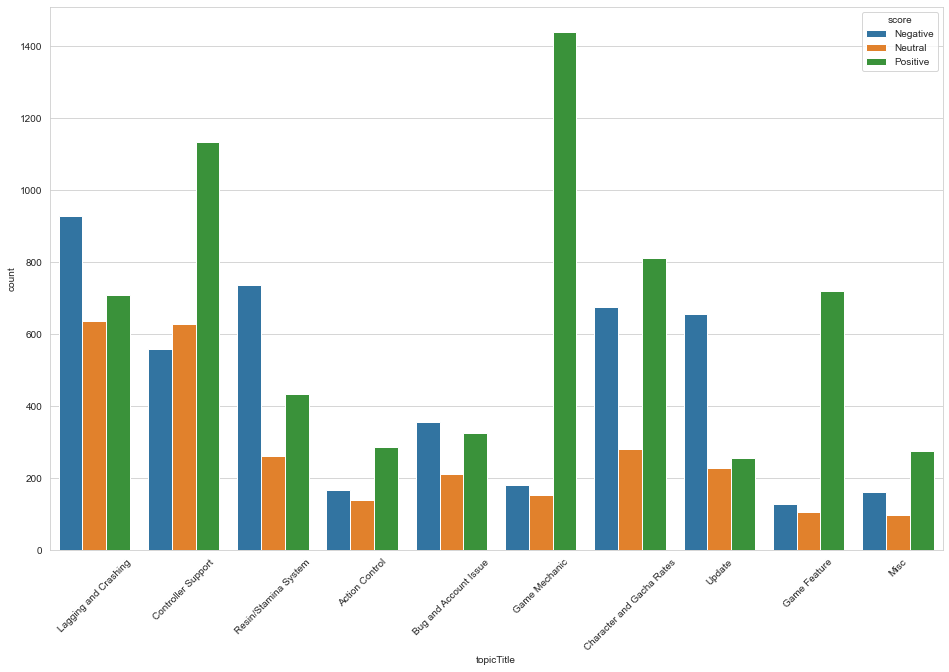

In [346]:
plt.figure(figsize=(16,10))
sns.countplot(x=topicReviews['topicTitle'], hue=topicReviews['score'])
plt.xticks(rotation=45)

In [347]:
# topicReviews[(topicReviews.topic == 5) & (topicReviews.score == 'Positive')].sort_values('topicContribution',ascending=0)

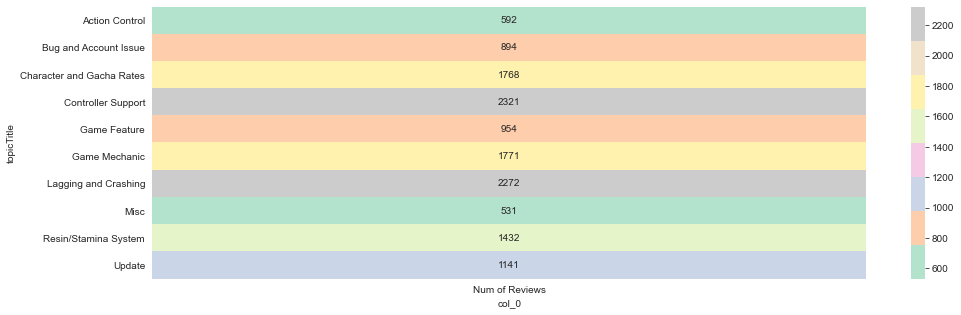

In [348]:
plt.figure(figsize=(16,5))
sns.heatmap(pd.crosstab(index=topicReviews['topicTitle'],columns=['Num of Reviews']),annot=True,fmt='',cmap='Pastel2')
plt.show()

In [349]:
data.sentiment_score.value_counts()

Positive    7155
Negative    5000
Neutral     3046
Name: sentiment_score, dtype: int64

# Conclusion

- There are 7155 Positive Reviews, 5000 Negative Reviews and 3046 Neutral Reviews
- From Gensim LDA models, there are 10 generated topics :
    0. : "Resin/Stamina System",
    1. : "Game Mechanic",
    2. : "Update",
    3. : "Misc",
    4. : "Action Control",
    5. : "Lagging and Crashing",
    6. : "Controller Support",
    7. : "Game Feature",
    8. : "Character and Gacha Rates",
    9. : "Bug and Account Issue"
    
- 2 most frequent topics are "Controller Support" with 2321 Reviews and "Lagging and Crashing" with 2272 Reviews
- 2 least frequent topics are "Misc" with 531 Reviews and "Action Controls" with 592 Reviews
- "Resin/Stamina System", "Update", "Account Issue" and "Lagging and Crashing" were dominated by Negative Reviews
- Game Mechanic and Game Features had the highest Positive Reviews percentage.

# Recommendation

1. For "Lagging and Crashing", players getting lag caused by bad connection, server capacity or minimum/low device specification. Crashing can happen because of user device specification or unstable application. It's recommended to optimize apps stability and add low setting for potato devices. Increasing server capacity isn't urgently needed because lag can be caused by user's bad connection.

2. For "Update" issue, players complained about the size of update which "too big" for them and low download speed while downloading update package. It's recomended to compress upgrade package and increase server capacity everytime update is available for download if possible.

3. For "Bug and Account Issue", players complained about customer support's slow or even not getting any response. It is recomended to make improvement on Customer Support section, because account is extremely important to access the game. Player also found some in-game bugs and should be fixed as soon as possible to prevent bug-exploit behavior.

4. For "Resin/Stamina System", player complained about resin/stamina system obstructing game progress. Player need to spend game currency that cost real money to refill stamina. it is recomended to increase stamina recharge rate or daily cap so player can increase their playtime and make further progress on their game.

In [330]:
# data.to_csv('bigram.csv',index=False)